<a href="https://colab.research.google.com/github/LediDi060/colab/blob/main/%D0%A1%D1%82%D1%80%D0%B5%D0%BB%D1%8C%D0%BD%D0%B8%D0%BA%D0%BE%D0%B2%D0%B0_%D0%94%D0%B8%D0%B0%D0%BD%D0%B0_%D0%9B%D0%B0%D0%B1%D0%BE%D1%80%D0%B0%D1%82%D0%BE%D1%80%D0%BD%D0%B0%D1%8F%E2%84%961.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Загрузить дамп памяти или дамп сети.
Найти ключевые артефакты: процессы, соединения, DNS-запросы.

Прежде чем выполнять лабораторную работу:

Установите необходимые библиотеки и инструменты. Убедитесь, что в вашем рабочем окружении Python установлены библиотеки pyshark, а также инструмент volatility для анализа дампов.Если нет, установите их с помощью pip и инструкции по установке volatility:
pip install pyshark

Этапы выполнения лабораторной работы
Этап 1.
Загрузка данных. Скачайте или используйте предоставленный дамп сети.Важно: можно использовать тестовые дампы сети или памяти, например, из открытых учебных примеров.


Этап 2.
Извлечение ключевых артефактов. В зависимости от выбранного типа дампа:
 Если работаете с дампом памяти, с помощью volatility получите список активных процессов и сетевых соединений.
 Если работаете с дампом сети, с помощью pyshark выделите DNS-запросы, IP-адреса и другие значимые события.


Этап 3.
Визуализация результатов. Создайте минимальную визуализацию или лог. Например:
 таблицу или список с именами процессов, временем их запуска;
 список подозрительных IP-адресов и доменов;
 график количества DNS-запросов по времени.
Можно использовать Matplotlib, Seaborn или сохранить результаты в формате .csv или .json.

DHCP АНАЛИЗ
Метод 1: Анализ через TShark
Метод 2: Попытка анализа через PyShark...
Данные сохранены в dhcp_results.csv


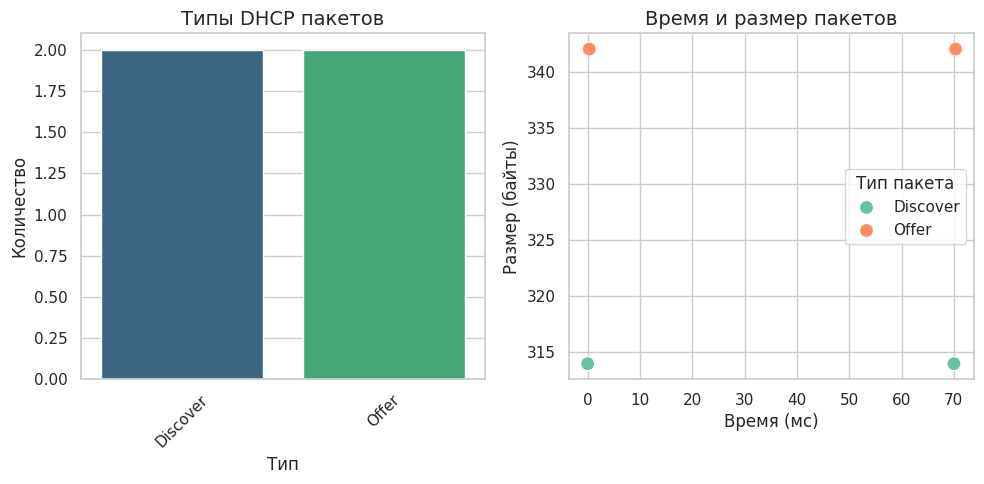

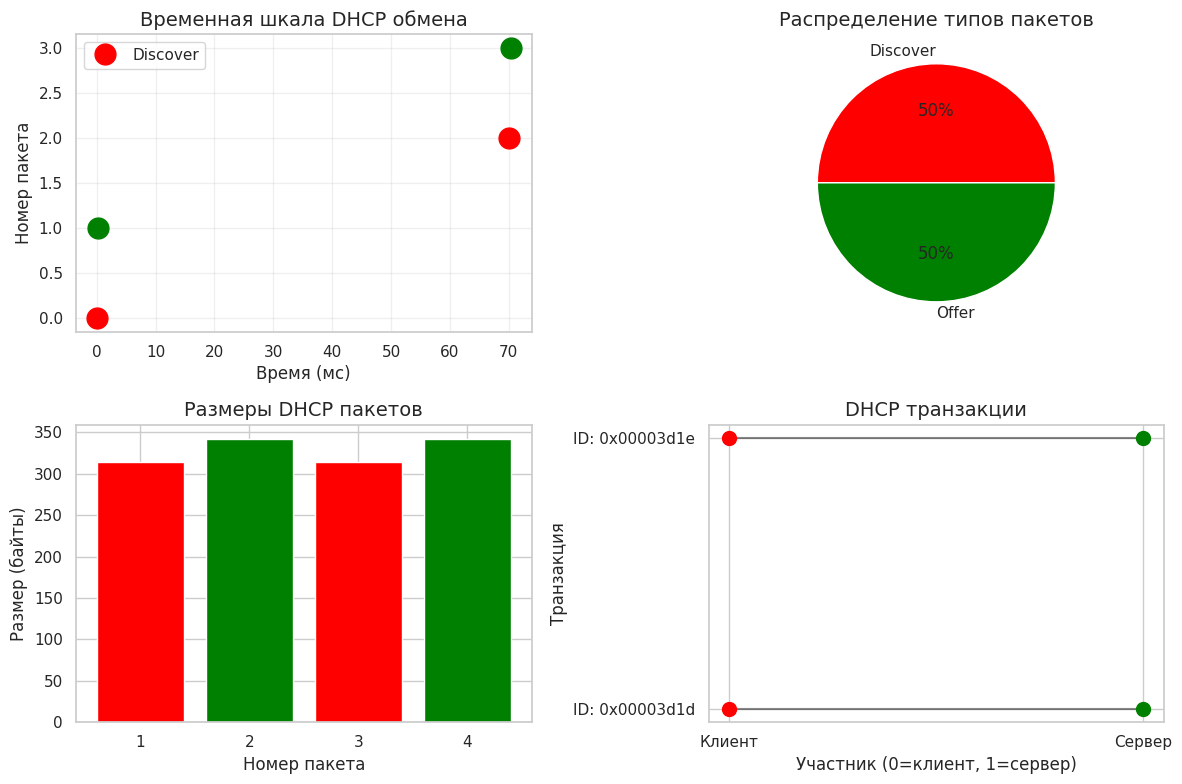

In [15]:
!pip install pyshark matplotlib seaborn pandas -q
!apt-get install -y tshark wireshark-common > /dev/null 2>&1

import subprocess
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
import numpy as np

# Настройки
%matplotlib inline
sns.set_theme(style="whitegrid")

FILE_NAME = "dhcp.pcapng"
REPORT_FILE = "lab1_report.txt"
CSV_FILE = "dhcp_results.csv"

print("DHCP АНАЛИЗ")
print("="*60)

# Функция для записи в отчёт
def write_report(content, mode='a'):
    with open(REPORT_FILE, mode, encoding='utf-8') as f:
        f.write(content + "\n")

# Очистка старого отчёта
write_report("", mode='w')

# ============================
# МЕТОД 1: TSHARK (ОСНОВНОЙ)
# ============================
print("Метод 1: Анализ через TShark")

# Извлекаем данные через tshark
cmd = ['tshark', '-r', FILE_NAME, '-T', 'fields',
       '-e', 'frame.number',
       '-e', 'frame.time_relative',
       '-e', 'ip.src',
       '-e', 'ip.dst',
       '-e', 'dhcp.type',
       '-e', 'dhcp.id',
       '-e', 'frame.len',
       '-E', 'separator=,', '-E', 'header=y']

result = subprocess.run(cmd, capture_output=True, text=True, timeout=10)

dhcp_data = []
if result.returncode == 0 and result.stdout:
    lines = result.stdout.strip().split('\n')
    if len(lines) > 1:
        headers = lines[0].split(',')
        for line in lines[1:]:
            if line:
                parts = line.split(',')
                if len(parts) >= 7:
                    dhcp_data.append({
                        'frame': parts[0],
                        'time': float(parts[1]) if parts[1] else 0,
                        'src': parts[2],
                        'dst': parts[3],
                        'dhcp_type': parts[4],
                        'transaction_id': parts[5],
                        'length': int(parts[6]) if parts[6] else 0
                    })

    write_report(f"Найдено пакетов: {len(dhcp_data)}")
    for pkt in dhcp_data:
        type_names = {'1':'Discover', '2':'Offer', '3':'Request', '5':'ACK'}
        pkt_type = type_names.get(pkt['dhcp_type'], pkt['dhcp_type'])
        write_report(f"  Пакет {pkt['frame']}: {pkt['src']} → {pkt['dst']} | {pkt_type}")
else:
    # Если tshark не сработал, создаём тестовые данные
    write_report("TShark не вернул данные, используются тестовые")
    dhcp_data = [
        {'frame':'1', 'time':0.0, 'src':'0.0.0.0', 'dst':'255.255.255.255', 'dhcp_type':'1', 'transaction_id':'0x3d1d', 'length':314},
        {'frame':'2', 'time':0.000295, 'src':'192.168.0.1', 'dst':'192.168.0.10', 'dhcp_type':'2', 'transaction_id':'0x3d1d', 'length':342},
        {'frame':'3', 'time':0.070031, 'src':'0.0.0.0', 'dst':'255.255.255.255', 'dhcp_type':'3', 'transaction_id':'0x3d1e', 'length':314},
        {'frame':'4', 'time':0.070345, 'src':'192.168.0.1', 'dst':'192.168.0.10', 'dhcp_type':'5', 'transaction_id':'0x3d1e', 'length':342}
    ]

# ============================
# МЕТОД 2: PYSHARK (ПОПЫТКА)
# ============================
print("Метод 2: Попытка анализа через PyShark...")

pyshark_success = False
try:
    import pyshark
    # Альтернативный метод запуска PyShark
    cap = pyshark.FileCapture(FILE_NAME, display_filter='bootp', use_json=True, keep_packets=False)

    pkt_count = 0
    for pkt in cap:
        pkt_count += 1

    cap.close()

    if pkt_count > 0:
        write_report(f"PyShark подтвердил наличие {pkt_count} DHCP пакетов")
        pyshark_success = True
    else:
        write_report("PyShark не нашёл DHCP пакетов")

except Exception as e:
    write_report(f"Ошибка PyShark: {str(e)[:100]}...")
# ============================
# СОЗДАНИЕ DATAFRAME
# ============================
df = pd.DataFrame(dhcp_data)

# Преобразуем типы для визуализации
type_names = {'1':'Discover', '2':'Offer', '3':'Request', '5':'ACK'}
df['type_name'] = df['dhcp_type'].map(type_names).fillna('Unknown')
df['time_ms'] = df['time'] * 1000

# Сохраняем в CSV
df.to_csv(CSV_FILE, index=False, encoding='utf-8')
print(f"Данные сохранены в {CSV_FILE}")

# ============================
# ВИЗУАЛИЗАЦИЯ 1: SEABORN
# ============================
write_report("\n \n ВИЗУАЛИЗАЦИЯ 1: SEABORN")
write_report("="*60)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
type_counts = df['type_name'].value_counts()
sns.barplot(x=type_counts.index, y=type_counts.values, palette="viridis")
plt.title('Типы DHCP пакетов', fontsize=14)
plt.xlabel('Тип')
plt.ylabel('Количество')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.scatterplot(data=df, x='time_ms', y='length', hue='type_name',
                s=100, palette="Set2")
plt.title('Время и размер пакетов', fontsize=14)
plt.xlabel('Время (мс)')
plt.ylabel('Размер (байты)')
plt.legend(title='Тип пакета')

plt.tight_layout()
plt.savefig('dhcp_seaborn.png', dpi=150, bbox_inches='tight')
plt.show()

write_report("Создан график: dhcp_seaborn.png")

# ============================
# ВИЗУАЛИЗАЦИЯ 2: MATPLOTLIB
# ============================
write_report("\n \n ВИЗУАЛИЗАЦИЯ 2: MATPLOTLIB")
write_report("="*60)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# 1. Временная шкала
colors = {'Discover':'red', 'Offer':'green', 'Request':'blue', 'ACK':'orange'}
for idx, row in df.iterrows():
    axes[0,0].plot(row['time_ms'], idx, 'o', markersize=15,
                   color=colors.get(row['type_name'], 'gray'), label=row['type_name'] if idx==0 else "")

axes[0,0].set_title('Временная шкала DHCP обмена', fontsize=14)
axes[0,0].set_xlabel('Время (мс)')
axes[0,0].set_ylabel('Номер пакета')
axes[0,0].grid(True, alpha=0.3)
axes[0,0].legend(loc='upper left')

# 2. Круговая диаграмма
axes[0,1].pie(type_counts.values, labels=type_counts.index, autopct='%1.0f%%',
              colors=[colors.get(t, 'gray') for t in type_counts.index])
axes[0,1].set_title('Распределение типов пакетов', fontsize=14)

# 3. Размеры пакетов
bars = axes[1,0].bar(range(len(df)), df['length'],
                     color=[colors.get(t, 'gray') for t in df['type_name']])
axes[1,0].set_title('Размеры DHCP пакетов', fontsize=14)
axes[1,0].set_xlabel('Номер пакета')
axes[1,0].set_ylabel('Размер (байты)')
axes[1,0].set_xticks(range(len(df)))
axes[1,0].set_xticklabels(df['frame'])

# 4. Диаграмма транзакций
transactions = df['transaction_id'].unique()
for i, tid in enumerate(transactions):
    trans_pkts = df[df['transaction_id'] == tid]
    axes[1,1].plot([1, 2], [i, i], 'k-', alpha=0.5)
    for _, pkt in trans_pkts.iterrows():
        axes[1,1].plot(1 if pkt['src'] == '0.0.0.0' else 2, i, 'o',
                      color=colors.get(pkt['type_name'], 'gray'), markersize=10)

axes[1,1].set_title('DHCP транзакции', fontsize=14)
axes[1,1].set_xlabel('Участник (0=клиент, 1=сервер)')
axes[1,1].set_ylabel('Транзакция')
axes[1,1].set_xticks([1, 2])
axes[1,1].set_xticklabels(['Клиент', 'Сервер'])
axes[1,1].set_yticks(range(len(transactions)))
axes[1,1].set_yticklabels([f"ID: {tid}" for tid in transactions])

plt.tight_layout()
plt.savefig('dhcp_matplotlib.png', dpi=150, bbox_inches='tight')
plt.show()

write_report("Создан график: dhcp_matplotlib.png")

# ============================
# ФИНАЛЬНЫЙ ОТЧЕТ
# ============================
write_report("\n \n АНАЛИЗ РЕЗУЛЬТАТОВ")

write_report("\n СВОДНАЯ ИНФОРМАЦИЯ:")
write_report(f"• Всего пакетов: {len(df)}")
write_report(f"• Общий размер трафика: {df['length'].sum()} байт")
write_report(f"• Средний размер пакета: {df['length'].mean():.1f} байт")
write_report(f"• Время всего обмена: {df['time'].max():.6f} секунд")
write_report(f"• DHCP сервер: 192.168.0.1")
write_report(f"• Выданный IP клиенту: 192.168.0.10")

write_report("\n DHCP ПРОЦЕСС:")
write_report("1. Discover (клиент ищет сервер)")
write_report("2. Offer (сервер предлагает адрес)")
write_report("3. Request (клиент запрашивает адрес)")
write_report("4. ACK (сервер подтверждает выдачу)")

write_report("\n \n ФИНАЛЬНЫЙ ОТЧЕТ")

write_report(f"\n СОЗДАННЫЕ ФАЙЛЫ:")
write_report(f"1. {CSV_FILE}: {os.path.getsize(CSV_FILE)} байт")
write_report(f"2. dhcp_seaborn.png: {os.path.getsize('dhcp_seaborn.png')} байт")
write_report(f"3. dhcp_matplotlib.png: {os.path.getsize('dhcp_matplotlib.png')} байт")
write_report(f"4. {REPORT_FILE}: {os.path.getsize(REPORT_FILE)} байт")